In [1]:
import pytz
import pandas
from datetime import datetime

import gtfs_kit as gk
import matplotlib.pyplot as plt

In [2]:
DATE = datetime(2024, 3, 20, tzinfo=pytz.timezone("Europe/Rome"))

In [3]:
vehicle_positions = pandas.read_parquet("../downloads/vehicle_positions.parquet")
vehicle_positions = vehicle_positions[vehicle_positions["vehicle.trip.start_date"].dt.date == DATE.date()]
len(vehicle_positions)

1182045

In [4]:
vehicle_positions["vehicle.trip.route_id"].nunique()

375

In [5]:
vehicle_positions = vehicle_positions[
    ~(
        (
            (vehicle_positions["vehicle.position.odometer"] == 0.0)
            & (vehicle_positions["vehicle.current_stop_sequence"] != 1)
        )  # fixes some weird occurences where the odometer drops to 0 in the middle of the trip
        | (
            (vehicle_positions["vehicle.position.odometer"] > 50.0)
            & (vehicle_positions["vehicle.current_stop_sequence"] == 1)
        )
    )
]
len(vehicle_positions)

879129

In [6]:
emitted_positions_count_by_route = vehicle_positions["vehicle.trip.route_id"].value_counts()
vehicle_positions = vehicle_positions[
    vehicle_positions["vehicle.trip.route_id"].isin(
        emitted_positions_count_by_route[emitted_positions_count_by_route > 3500].index
    )
]
len(vehicle_positions)

662300

In [7]:
vehicle_positions["vehicle.trip.route_id"].nunique()

105

In [6]:
# feed = gk.read_feed("../downloads/schedule_updates/2024-03-20T06_34_14.zip", dist_units="km")

## Routes

### Number of planned routes

In [6]:
routes = feed.get_routes()
route_ids = routes["route_id"].unique()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/fra/.cache/pypoetry/virtualenvs/datac-analysis-5tLNiopQ-py3.13/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
    ~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_46288/1357941207.py", line 1, in <module>
    routes = feed.get_routes()
             ^^^^
NameError: name 'feed' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/fra/.cache/pypoetry/virtualenvs/datac-analysis-5tLNiopQ-py3.13/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 2144, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
        etype, value, tb, tb_offset=tb_offset
    )
  File "/home/fra/.cache/pypoetry/virtualenvs/datac-analysis-5tLNiopQ-py3.13/lib/python3.13/site-packages/IPython/core/ultratb.py", line 1435, in structured_traceba

In [ ]:
def get_monitored_route_ids(vehicle_positions: pandas.DataFrame):
    return vehicle_positions["vehicle.trip.route_id"].unique()

In [ ]:
monitored_route_ids = get_monitored_route_ids(vehicle_positions)
unimonitored_route_ids = set(route_ids) - set(monitored_route_ids)

### % of monitored routes

In [7]:
NUM_METRO_LINES = 4

round(len(monitored_route_ids) / (len(route_ids) - NUM_METRO_LINES) * 100, 1)

95.2

### Unmonitored routes

In [8]:
routes[routes["route_id"].isin(unimonitored_route_ids)][["route_short_name", "route_long_name", "route_url"]]

,route_short_name,route_long_name,route_url
11,551,<NA>,https://muoversiaroma.it/it/linea?numero=551
28,500,<NA>,https://muoversiaroma.it/it/linea?numero=500
55,246,<NA>,https://muoversiaroma.it/it/linea?numero=246
58,021,<NA>,https://muoversiaroma.it/it/linea?numero=021
236,043,<NA>,https://muoversiaroma.it/it/linea?numero=043
242,113,<NA>,https://muoversiaroma.it/it/linea?numero=113
244,246P,<NA>,https://muoversiaroma.it/it/linea?numero=246P
246,351,<NA>,https://muoversiaroma.it/it/linea?numero=351
254,319,<NA>,https://muoversiaroma.it/it/linea?numero=319
269,718,<NA>,https://muoversiaroma.it/it/linea?numero=718


## Route Analysis

In [8]:
def compute_commercial_speed_per_route_and_trip(
    vehicle_positions: pandas.DataFrame,
    min_speed_cutoff: float = 0.0,
    max_speed_cutoff: float = 35.0,
) -> pandas.DataFrame:
    relevant_cols = [
        "vehicle.trip.route_id",
        "vehicle.trip.trip_id",
        "vehicle.timestamp",
        "vehicle.position.odometer",
        "vehicle.current_stop_sequence",
    ]
    relevant_view = vehicle_positions[relevant_cols]

    odometer_and_timestamp_minmax = relevant_view.groupby(
        ["vehicle.trip.route_id", "vehicle.trip.trip_id"], observed=False
    ).agg({"vehicle.timestamp": ["min", "max", "mean"], "vehicle.position.odometer": ["min", "max"]})

    trips = (
        (
            (
                (
                    odometer_and_timestamp_minmax["vehicle.position.odometer"]["max"]
                    - odometer_and_timestamp_minmax["vehicle.position.odometer"]["min"]
                )
                / 1000  # km
            )
            / (
                (
                    odometer_and_timestamp_minmax["vehicle.timestamp"]["max"]
                    - odometer_and_timestamp_minmax["vehicle.timestamp"]["min"]
                ).dt.seconds
                / 3600  # hours
            )
        )
        .rename("vehicle.commercial_speed_kmh")
        .to_frame()
        .assign(**{"vehicle.timestamp.mean": odometer_and_timestamp_minmax["vehicle.timestamp"]["mean"]})
    )

    return trips[
        (min_speed_cutoff < trips["vehicle.commercial_speed_kmh"])
        & (trips["vehicle.commercial_speed_kmh"] < max_speed_cutoff)
    ]

In [9]:
trips = compute_commercial_speed_per_route_and_trip(vehicle_positions)

In [10]:
trips[["vehicle.commercial_speed_kmh"]].describe()

,vehicle.commercial_speed_kmh
count,14202.000000
mean,12.329209
std,6.424385
min,0.000933
25%,8.121528
50%,12.221031
75%,16.138639
max,34.978412


In [11]:
trips[["vehicle.commercial_speed_kmh"]].groupby(level=0, observed=False).mean().dropna().sort_values(
    by="vehicle.commercial_speed_kmh"
).round(2)

,vehicle.commercial_speed_kmh
vehicle.trip.route_id,
64,3.10
492,3.38
62,3.50
51,3.50
46,3.52
...,...
508,20.47
04,20.49
075,20.51


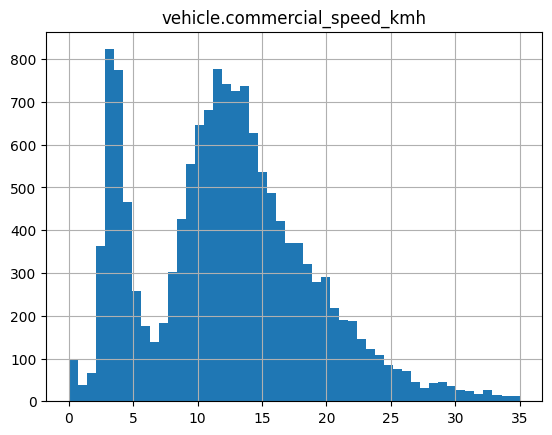

In [12]:
trips[["vehicle.commercial_speed_kmh"]].hist(bins=50)
plt.show()

In [27]:
from datetime import timedelta

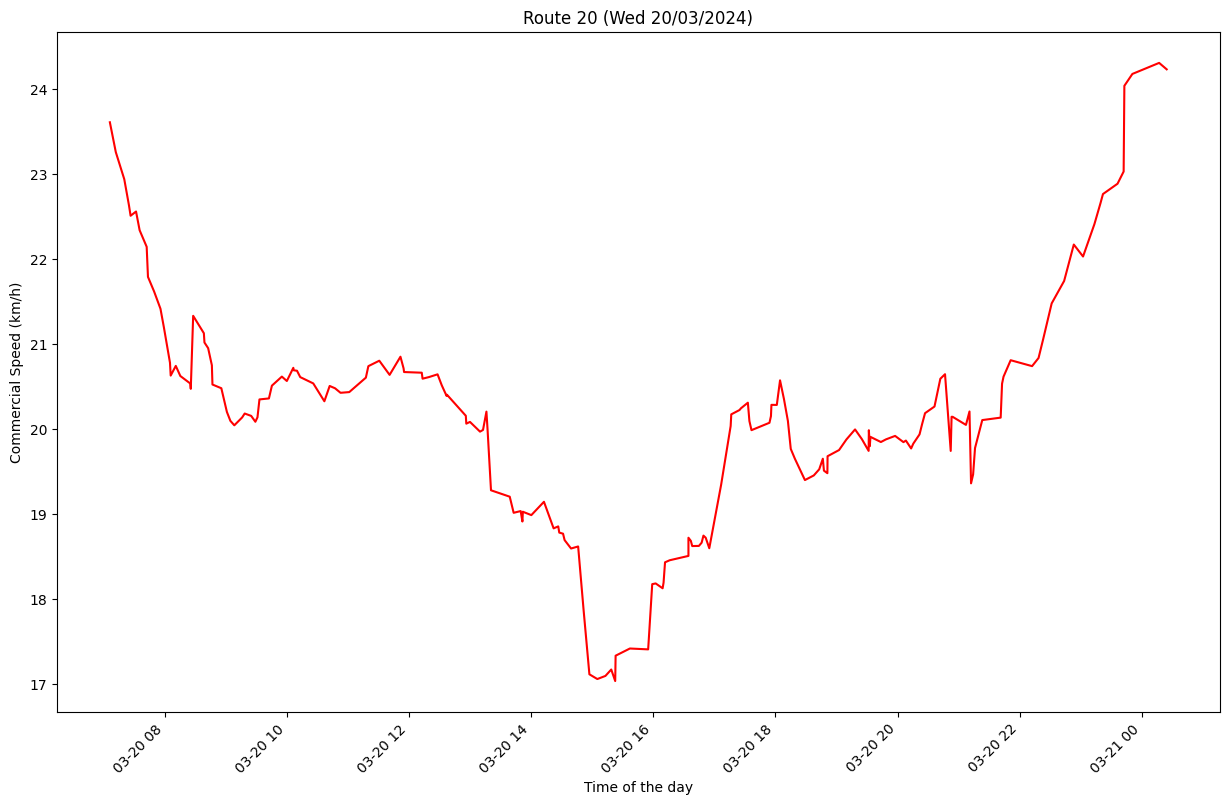

In [ ]:
ROUTE_ID = "20"

(
    trips.loc[ROUTE_ID]
    .set_index("vehicle.timestamp.mean")
    .sort_index()
    .interpolate()
    .rolling(25)
    .mean()
    .plot(
        rot=45,
        title=f"Route {ROUTE_ID} (Wed 20/03/2024)",
        ylabel="Commercial Speed (km/h)",
        xlabel="Time of the day",
        legend=False,
        figsize=(15, 10),
        color="red"
    )
)
plt.show()

In [ ]:
timedelta(minutes=5)

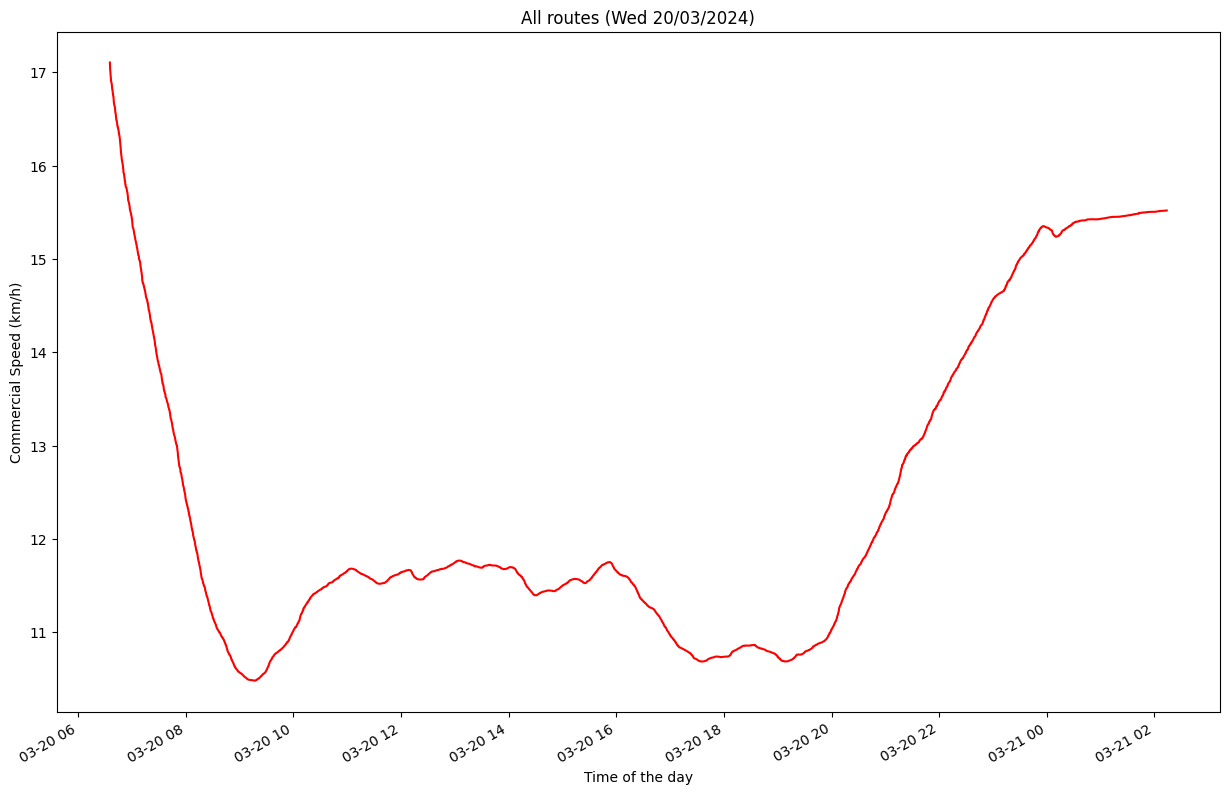

In [105]:
trips.set_index("vehicle.timestamp.mean").sort_index().rolling(timedelta(minutes=15), min_periods=2).mean().rolling(
    1000
).mean().plot(title="All routes (Wed 20/03/2024)", figsize=(15, 10), xlabel="Time of the day", ylabel="Commercial Speed (km/h)", legend=False, color="red")
plt.show()

## Failed Trips

In [12]:
route_planned_trips = route_timetable["trip_id"].unique()
route_actual_trips = route_vehicle_positions["vehicle.trip.trip_id"].unique()
route_failed_trips = set(route_planned_trips) - set(route_actual_trips)
len(route_planned_trips), len(route_failed_trips)

(208, 35)

In [13]:
route_timetable[(route_timetable["trip_id"].isin(route_failed_trips)) & (route_timetable["stop_sequence"] == 1)][
    ["trip_id", "trip_headsign", "departure_time", "date"]
]

,trip_id,trip_headsign,departure_time,date
32,0#4657-3,MUSE,05:28:00,20240320
185,0#4657-4,ZAMA,05:50:00,20240320
425,0#4657-5,MUSE,06:31:00,20240320
621,0#4660-4,MUSE,07:02:00,20240320
740,0#4657-6,ZAMA,07:22:00,20240320
936,0#4650-3,MUSE,07:46:00,20240320
981,0#4660-5,ZAMA,07:52:00,20240320
1161,0#4650-4,ZAMA,08:19:00,20240320
1192,0#4657-7,MUSE,08:27:00,20240320
1372,0#4660-6,MUSE,08:56:00,20240320


In [23]:
trip_positions = route_vehicle_positions[route_vehicle_positions["vehicle.trip.trip_id"] == "0#4648-3"][
    ["vehicle.position.latitude", "vehicle.position.longitude"]
].values